This notebook is for creating the base ML model.

In [1]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [3]:
max = df['busyness'].max()
min = df['busyness'].min()
df['busyness'] =  2 * (df['busyness'] - min)/(max - min) - 1

In [28]:
df.shape

(7319643, 3)

In [4]:
df.head()

datetime  location  busyness
0 2021-01-01         3 -0.952441
1 2021-01-01         4 -0.915411
2 2021-01-01         5 -0.993465
3 2021-01-01         6 -0.986930
4 2021-01-01         7 -0.821383

In [5]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01 -0.952441
4       2021-01-01 -0.915411
5       2021-01-01 -0.993465
6       2021-01-01 -0.986930
7       2021-01-01 -0.821383


In [6]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [7]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path="base_model"
)
print('we made the predictor')

we made the predictor


In [8]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'base_model'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       3.45 GB / 15.90 GB (21.7%)
Disk Space Avail:   2135.30 GB / 2794.50 GB (76.4%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%), 261 time series. M

In [9]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.204658     693.438165          94.222855          7
1     SeasonalNaive  -1.339581       1.106288           4.711678          2
2               ETS  -1.821774      73.185608           5.088301          5
3  RecursiveTabular  -2.191026     609.073881         362.240478          3
4             Naive  -2.354159       4.080232           5.276778          1
5     DirectTabular  -3.186820       5.992157          15.605451          4
6             Theta  -4.461306      35.251187           4.914639          6


In [10]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                 mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
3       2024-01-01 23:00:00 -0.938173 -0.952379 -0.947502 -0.943986 -0.940981   
        2024-01-02 00:00:00 -0.958865 -0.974002 -0.968806 -0.965059 -0.961858   
        2024-01-02 01:00:00 -0.942384 -0.958235 -0.952793 -0.948870 -0.945517   
        2024-01-02 02:00:00 -0.948572 -0.965025 -0.959377 -0.955304 -0.951825   
        2024-01-02 03:00:00 -0.962675 -0.979658 -0.973828 -0.969624 -0.966032   
...                               ...       ...       ...       ...       ...   
110     2022-04-23 13:00:00 -0.998948 -1.039257 -1.025420 -1.015442 -1.006917   
        2022-04-23 14:00:00 -0.998940 -1.039259 -1.025418 -1.015438 -1.006911   
        2022-04-23 15:00:00 -0.998799 -1.039126 -1.025282 -1.015300 -1.006771   
        2022-04-23 16:00:00 -0.998792 -1.039128 -1.025281 -1.015297 -1.006766   
        2022-04-23 17:00:00 

data with frequency 'None' has been resampled to frequency 'h'.


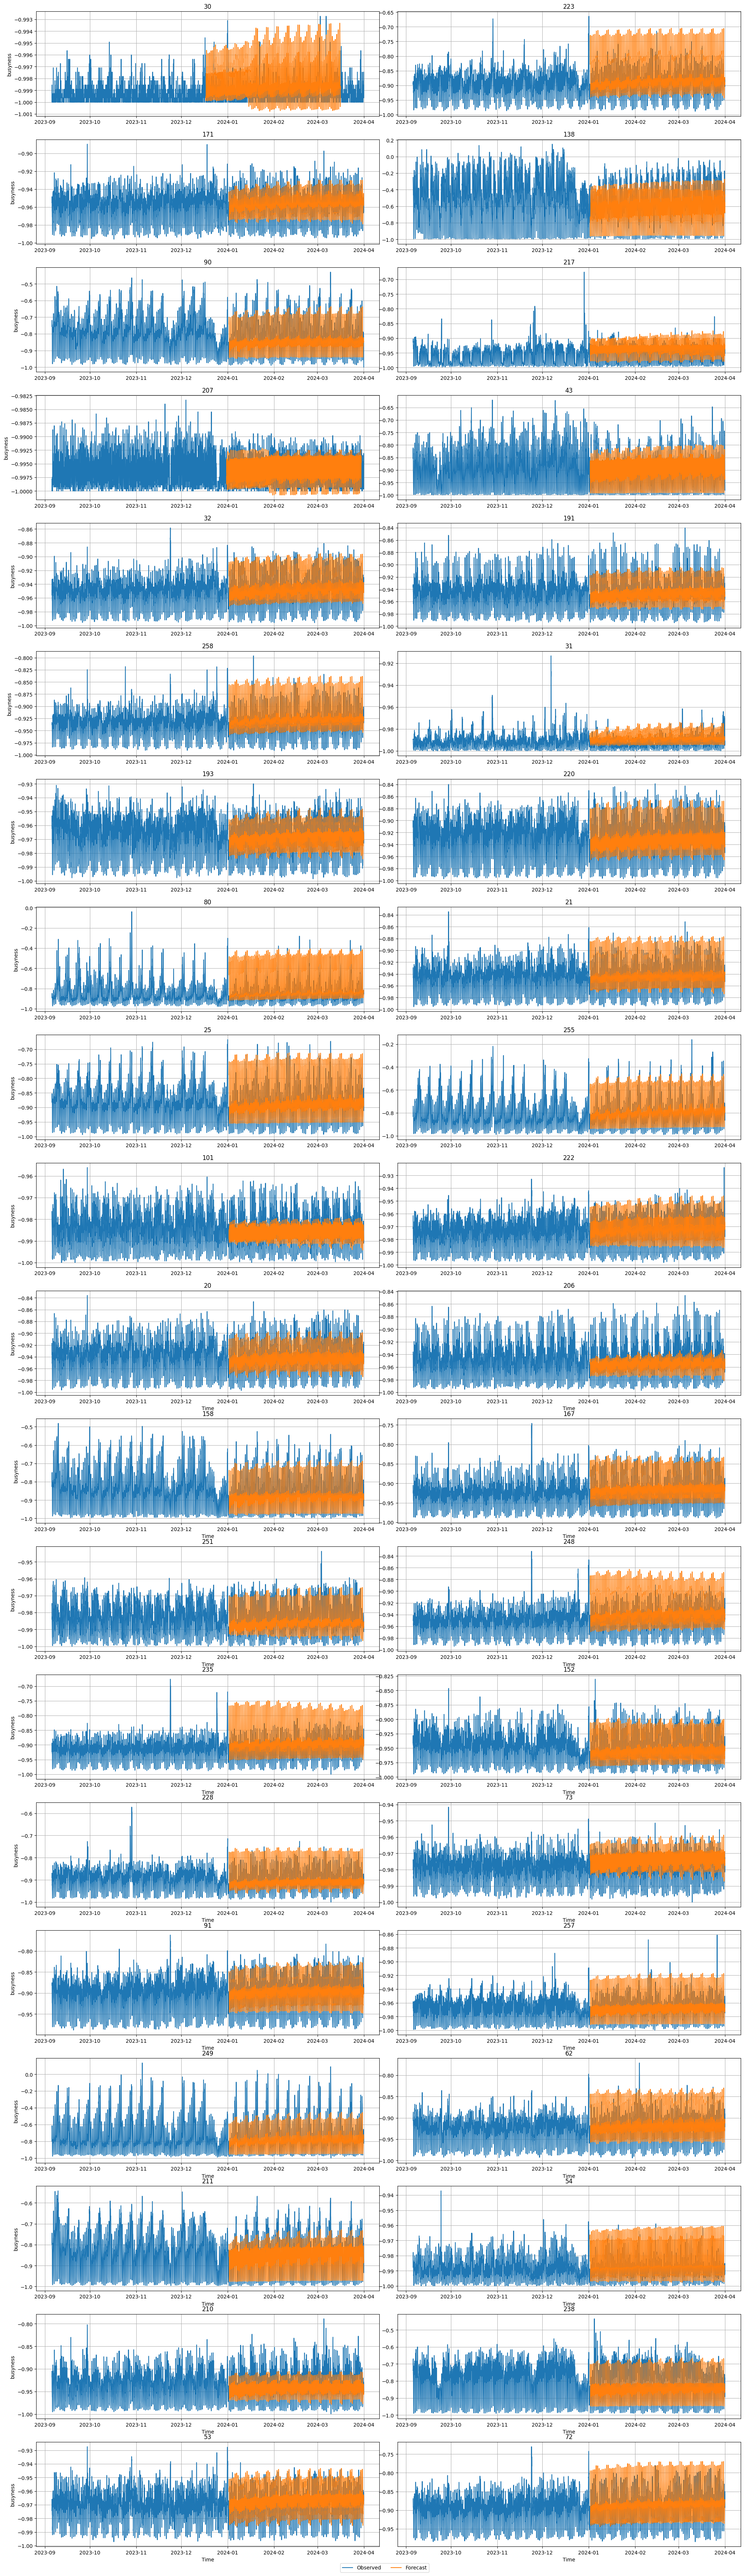

In [11]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=40)


In [12]:
ax = plot.gca()
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
ax.set_xlim([xmin, xmax])

(19783.0, 19813.999988425927)

In [13]:
plot.savefig("test-plot.png")

In [14]:
plt.show()

In [15]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -2.5949616246727714}